In [1]:
import numpy as np
import h5py
import pywt

import sys
sys.path.append("/home/qyli/work2025/densityfield/pipeline")
import gridsmooth, lssfuncs
import sampling, gridsmooth, fouriertransf, exttool, phyconvert, exttool, surveyvol

import matplotlib.pyplot as plt
import numba as nb
import pandas as pd

from scipy.interpolate import interp1d

import sys
sys.path.append("/home/qyli/work2025/densityfield/project2/xi")
import functions as powerfunc

import importlib
importlib.reload(powerfunc)

<module 'functions' from '/home/qyli/work2025/densityfield/project2/xi/functions.py'>

In [24]:
def camb_result(redshift):
    import camb
    from camb import model, initialpower

    print("CAMB")
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.66, ombh2=0.02242, omch2=0.11933)
    pars.InitPower.set_params(As=2.1e-9, ns=0.9665)
    pars.set_matter_power(redshifts=[redshift], kmax=10.0)  #kmax=10 h/Mpc

    #linear
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints=200)

    #non-linear
    pars.NonLinear = model.NonLinear_both
    results.calc_power_spectra(pars)
    kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints=200)
    return kh, pk, kh_nonlin, pk_nonlin

def Nbodykit_result(pos, mass, Lbox, Ngrid):
    from nbodykit.lab import ArrayCatalog, FFTPower, FFTCorr  
    cat = ArrayCatalog({'Position': pos,
                       'Mass': mass})  
    mesh = cat.to_mesh(
        BoxSize=Lbox,
        Nmesh=Ngrid,
        resampler='db12',     # 分配核：'ngp', 'cic', 'tsc'
        compensated=False,    # 是否做CIC补偿
        interlaced=False,     # 是否插值去aliasing
        weight='Mass',
        position='Position'
    )  
    density = mesh.paint(mode='real')  
    r = FFTPower(mesh, mode='1d', kmin = 1e-2, kmax = 10)
    Pk = r.power
    k_bin_kit = Pk['k']; Pk_bin_kit = Pk['power']
    return k_bin_kit, Pk_bin_kit

def show_b_value(halo_mass, mlim, redz):

    def compute_bias_facter(halo_mass, mlim = 12, redz = 0, modelname = 'bhattacharya11'):
        '''compute halo bias facter (Eq10, Wang09)
        halo_mass: log Mh, Msun/h
        mlim: mass limit used to calculation
        '''
        from colossus.lss import bias
        from colossus.cosmology import cosmology
        from scipy.stats import binned_statistic

        cosmo = cosmology.setCosmology('planck18')
        print(cosmo.H0, cosmo.Om0)

        xbin = np.logspace(mlim, 16, 50+1)
        xmed = (xbin[1:] + xbin[:-1])/2
        b = bias.haloBias(M=xmed, z=redz, mdef='200m', model=modelname)    
        bin_value, bin_edges, binnumber = binned_statistic(10**halo_mass, 10**halo_mass, statistic = 'sum', bins = xbin)

        bh = np.sum(bin_value * b) / np.sum(10**halo_mass)
        return bh

    modelnames = ['cole89', 'jing98', 'sheth01', 'seljak04', 'pillepich10', 'tinker10', 'bhattacharya11', 'comparat17']
    bhs = np.zeros(len(modelnames))
    for ii,modelname in enumerate(modelnames):
        bhs[ii] = compute_bias_facter(halo_mass, mlim, redz, modelname = modelname)
    return modelnames, bhs

def power_spectrum_from_field(pos, mass, Lbox, Ngrid, survey_volume, Vsurvey, resampler = 'CIC'):
    
    rho = np.zeros((Ngrid, Ngrid, Ngrid), dtype=np.float32)
    x_phi, W_phi = lssfuncs.define_window_function(resampler)
    rho = lssfuncs.assign_mass_numba(pos, x_phi, W_phi, rho, Lbox, Ngrid, resampler, mass)

    surveyden = np.sum(mass) / survey_volume
    delta_field_grid = rho / surveyden - 1

    bins = np.logspace(-2,0,60+1)
    k_bin, Pk_bin, _, Nmodes = lssfuncs.compute_power_spectrum(delta_field_grid, Lbox, Ngrid, Vsurvey, 1, bins, resampler = 'CIC')
    
    return k_bin[Nmodes > 0], Pk_bin[Nmodes > 0]

In [3]:
spnum = 127

filept = '/home/cossim/qyli/Jiutian/M1000/snapshot/sample_M1000_snapshot%03d_POS_rd0.01.hdf5'%spnum
dpt = h5py.File(filept, 'r')
ptpos = dpt['POS'][:]
np.random.seed(123)
rdpt = np.random.choice(range(len(ptpos)), size = int(len(ptpos)*0.01), replace = False)
ptpos = ptpos[rdpt]
dpt.close()

filepath = '/home/qyli/work2025/densityfield'
data = h5py.File(filepath + '/data/sample_fof_M1000_snapshot%03d_halos.hdf5'%spnum, 'r')
halo_mass = data['group_mass'][0,:]
halo_pos = data['group_pos'][0,:,:]
sel_halo = (halo_mass > 12)
halo_mass = halo_mass[sel_halo]
halo_pos = halo_pos[sel_halo]

In [25]:
# kh, pk, kh_nonlin, pk_nonlin = camb_result(0.0)
# k_bin_kit, Pk_bin_kit = Nbodykit_result(ptpos, np.ones(len(ptpos)), 1000, 256)
# k_halo, Pk_halo = Nbodykit_result(halo_pos, 10**halo_mass, 1000, 256)
k_, Pk_ = power_spectrum_from_field(halo_pos, 10**halo_mass, 1000, 256, 256**3, 1000**3, resampler = 'CIC')

/home/qyli/work2025/densityfield/pipeline/lssfuncs.py:427: RuntimeWarning: invalid value encountered in true_divide
  return np.where(x == 0, 1.0, np.sin(x)/x)


k min and max are  0.0 1.3929979117318794


/home/qyli/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/qyli/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'z = 0.0')

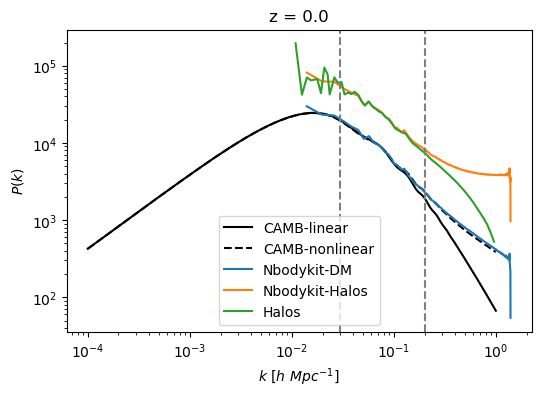

In [23]:
plt.figure(dpi = 100)

#CAMB result
plt.plot(kh, pk[0], c = 'k', ls = '-', label = 'CAMB-linear')
plt.plot(kh_nonlin, pk_nonlin[0], c = 'k', ls = '--', label = 'CAMB-nonlinear')

#Nbody
plt.plot(k_bin_kit, Pk_bin_kit, label = 'Nbodykit-DM')
plt.plot(k_halo, Pk_halo, label = 'Nbodykit-Halos')

#
plt.plot(k_, Pk_, label = 'Halos')

plt.legend()
plt.axvline(0.2, color = 'grey', ls = '--')
plt.axvline(0.03, color = 'grey', ls = '--')
plt.loglog()

plt.xlabel(r'$k\ [h\ Mpc^{-1}]$')
plt.ylabel(r'$P(k)$')
plt.title('z = 0.0')

2.393004749979577
67.66 0.3111
67.66 0.3111
67.66 0.3111
67.66 0.3111
67.66 0.3111
67.66 0.3111
67.66 0.3111
67.66 0.3111


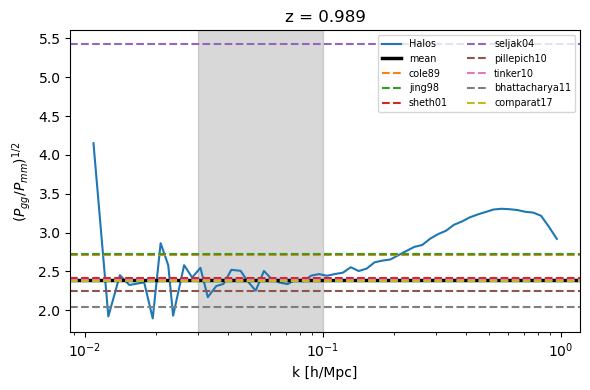

In [7]:
interp_pk = interp1d(kh, pk[0], kind='linear', fill_value="intrapolate")

plt.figure(dpi = 100)

Pk_target = interp_pk(k_)
plt.plot(k_, (Pk_/Pk_target)**0.5, '-', c = 'C0', label = 'Halos')

idx_ = (k_ > 0.03) & (k_ < 0.1)
bias = np.mean((Pk_[idx_]/Pk_target[idx_])**0.5)
plt.axhline(bias, color = 'k', lw = 2.5, label = 'mean')
print(bias)

modelnames, bhs = show_b_value(halo_mass, mlim = 12, redz = 0.989)
for i in range(len(modelnames)):
    plt.axhline(bhs[i], label = modelnames[i], ls = '--', color = 'C%s'%(i+1))

plt.axvspan(0.03, 0.1, color = 'grey', alpha=0.3) 
plt.xscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'$(P_{gg}/P_{mm})^{1/2}$')
plt.legend(fontsize = 'x-small', ncol = 2)
plt.title('z = 0.989')

plt.tight_layout()

## test for mock sample

In [11]:
importlib.reload(lssfuncs)

filerecon = '../../data/9tianM_SpecNGC/vel_9tianM_SpecNGC_mlim12_Ngrid256_sigma1.0_z0.0-0.4.hdf5'
drecon = h5py.File(filerecon, "r")
in_survey_indices = drecon['in_survey_indices'][:]
out_survey_indices = drecon['out_survey_indices'][:]

Lbox = drecon["Lbox"][:]
Ngrid = drecon["Ngrid"][:]
halo_mass = drecon["group_mass"][:]
halo_coor = drecon["origin_coordinate"][:]

ra = halo_coor[:,0]; dec = halo_coor[:,1]; redshift = halo_coor[:,2]
x_cart, y_cart, z_cart = phyconvert.equatorial_to_cartesian(ra, dec, redshift)
halo_cert = np.c_[x_cart, y_cart, z_cart] + drecon['posmov'][:]

def density_from_window_function(pos, Ngrid, Lbox, resampler, survey_volume, outer_indices, halomass):
    '''calculate Pk from group pos using a specific function
    halomass: halo mass, in unit of Msun/h
    '''

    rho = np.zeros((Ngrid, Ngrid, Ngrid), dtype=np.float32)
    x_phi, W_phi = lssfuncs.define_window_function(resampler)
    rho = lssfuncs.assign_mass_numba(pos, x_phi, W_phi, rho, Lbox, Ngrid, resampler, halomass)

    surveyden = np.sum(halomass) / survey_volume
    delta_field_grid = rho / surveyden - 1
    iidx, jjdx, kkdx = outer_indices.T
    delta_field_grid[iidx, jjdx, kkdx] = 0.

    return delta_field_grid

survey_volume = len(in_survey_indices)
delta_field_grid = density_from_window_function(halo_cert, Ngrid[0], Lbox[0], 'CIC', survey_volume, out_survey_indices, 10**halo_mass)

print("calculate power spectrum")
bins = np.logspace(-2,0,60+1)
Vsurvey = (len(in_survey_indices) / Ngrid[0]**3) * Lbox[0]**3
# Vsurvey = Lbox[0]**3
k_bin, Pk_bin, Nmodes = lssfuncs.compute_power_spectrum(delta_field_grid, Lbox[0], Ngrid[0], Vsurvey, 1, bins)
valid = Nmodes > 0
k_bin = k_bin[valid]
Pk_bin = Pk_bin[valid]

calculate power spectrum
k min and max are  0.0 0.6882400749663434


In [3]:
import camb
from camb import model, initialpower

print("CAMB")
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.66, ombh2=0.02242, omch2=0.11933)
pars.InitPower.set_params(As=2.1e-9, ns=0.9665)
pars.set_matter_power(redshifts=[0.29], kmax=10.0)  #kmax=10 h/Mpc

#linear
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints=200)

#non-linear
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints=200)

CAMB


Text(0, 0.5, '$P(k)$')

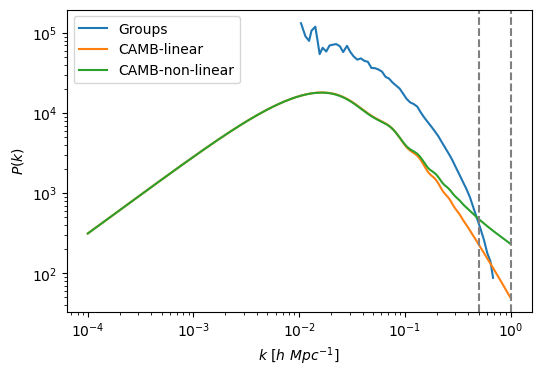

In [12]:
plt.figure(dpi = 100)

plt.plot(k_bin, Pk_bin, label = 'Groups')
plt.plot(kh, pk[0], label = 'CAMB-linear')
plt.plot(kh_nonlin, pk_nonlin[0], label = 'CAMB-non-linear')
# plt.plot(k_bin_kit, Pk_bin_kit, label = 'Nbodykit')

plt.legend()
plt.axvline(0.5, color = 'grey', ls = '--')
plt.axvline(1.0, color = 'grey', ls = '--')
plt.loglog()

plt.xlabel(r'$k\ [h\ Mpc^{-1}]$')
plt.ylabel(r'$P(k)$')

No handles with labels found to put in legend.


2.00809360192795


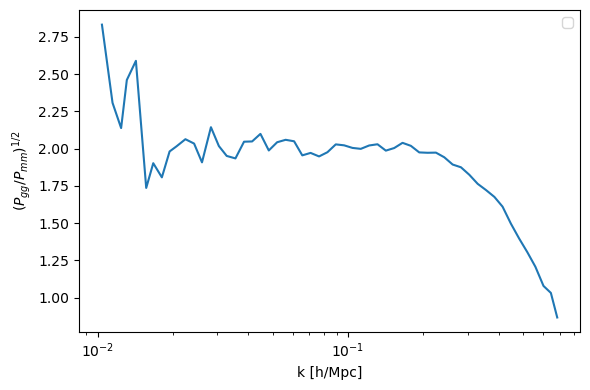

In [13]:
interp_pk = interp1d(kh, pk[0], kind='linear', fill_value="intrapolate")

plt.figure(dpi = 100)
xx = k_bin; yy = Pk_bin
Pk_target = interp_pk(xx)
plt.plot(xx, (yy/Pk_target)**0.5, '-', c = 'C0')


plt.xscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'$(P_{gg}/P_{mm})^{1/2}$')
plt.legend()

idx_ = (xx > 0.03) & (xx < 0.1)
bb = (yy/Pk_target)**0.5
print(np.mean(bb[idx_]))
plt.tight_layout()

### check velocity along line-of-sight

In [14]:
import numpy as np

def los_velocity(vx, vy, vz, ra, dec, deg=True):
    """
    Compute line-of-sight velocity.

    Parameters
    ----------
    vx, vy, vz : float or array
        Cartesian velocity components.
    ra, dec : float or array
        Right ascension and declination.
    deg : bool
        If True, ra/dec are in degrees.

    Returns
    -------
    v_los : float or array
        Line-of-sight velocity.
    """
    if deg:
        ra = np.deg2rad(ra)
        dec = np.deg2rad(dec)

    nx = np.cos(dec) * np.cos(ra)
    ny = np.cos(dec) * np.sin(ra)
    nz = np.sin(dec)

    return vx * nx + vy * ny + vz * nz


In [22]:
filerecon = '../../data/9tianM_SpecNGC/vel_9tianM_SpecNGC_mlim12_Ngrid256_sigma1.0_z0.0-0.4.hdf5'
drecon = h5py.File(filerecon, "r")

halo_coor_iter = drecon['corr_coordinate'][:] 
halo_vel_corr = drecon['corr_halo_vel'][:]
v_proj = drecon['velocity_los'][:]
corr_halo_pos = drecon['corr_halo_pos'][:]
Lbox = drecon['Lbox'][:]

ra = halo_coor[:,0]; dec = halo_coor[:,1]
vx = halo_vel_corr[:,0]; vy = halo_vel_corr[:,1]; vz = halo_vel_corr[:,2]; 
halo_prog_vel = los_velocity(vx, vy, vz, ra, dec, deg=True)

(0.0, 2024.0)

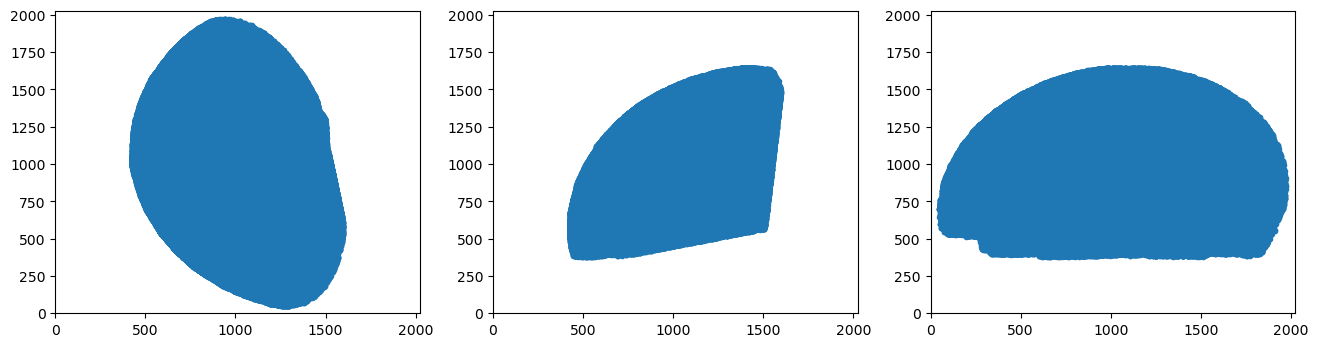

In [23]:
plt.figure(dpi = 100, figsize = (16,4))
plt.subplot(131)
plt.plot(corr_halo_pos[:,0], corr_halo_pos[:,1], '.', rasterized = False)
plt.xlim(0, Lbox[0])
plt.ylim(0, Lbox[0])

plt.subplot(132)
plt.plot(corr_halo_pos[:,0], corr_halo_pos[:,2], '.', rasterized = False)
plt.xlim(0, Lbox[0])
plt.ylim(0, Lbox[0])

plt.subplot(133)
plt.plot(corr_halo_pos[:,1], corr_halo_pos[:,2], '.', rasterized = False)
plt.xlim(0, Lbox[0])
plt.ylim(0, Lbox[0])

## show survey edge

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import alphashape
from shapely.geometry import Point,Polygon,MultiPoint
from shapely.vectorized import contains
from shapely.ops import unary_union, polygonize
from scipy.spatial import Delaunay

from astropy.coordinates import CartesianRepresentation, SkyCoord
import astropy.units as u

import phyconvert, exttool


def comp_survey_edge(ra, dec, valpha = True, showfig = False):
    '''compute survey edge with alphashape package
    '''
    points = np.vstack((ra, dec)).T
    if valpha:
        alpha = 1
    else:
        alpha = alphashape.optimizealpha(points)
    shape = alphashape.alphashape(points, alpha)  

    if shape.geom_type == 'MultiPolygon':
        survey_polygon = unary_union(shape)
    else:
        survey_polygon = shape

    if showfig:
        fig, ax = plt.subplots(figsize=(7, 6))
        ax.scatter(ra, dec, s=2, c='blue', label='Galaxies')
        ax.set_xlabel('RA [deg]')
        ax.set_ylabel('Dec [deg]')
        ax.set_title('Alpha Shape of Galaxy Survey Region')
        ax.invert_xaxis()

        # plot edges
        if shape.geom_type == 'Polygon':
            x, y = shape.exterior.xy
            ax.plot(x, y, 'r-', lw=2, label='Alpha Shape')
        elif shape.geom_type == 'MultiPolygon':
            for geom in shape.geoms:
                x, y = geom.exterior.xy
                ax.plot(x, y, 'r-', lw=2, label='Alpha Shape')
                
        ax.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # x, y = shape.exterior.xy
    # survey_polygon = [(x0, y0) for x0, y0 in zip(x, y)]
    return survey_polygon

#======================================================================================
def comp_survey_indices(Lbox, Ngrid, survey_ra, survey_dec, posmov, z_min, z_max):
    '''compute the indices of survey volume

    grid_positions: (Ngrid**3, 3)
    posmov: moving position for grids
    z_min, z_max: minimal and maximum redshift
    '''

    #produce grid positiion
    ix, iy, iz = np.indices((Ngrid[0], Ngrid[1], Ngrid[2]))
    grid_indices = np.stack([ix.ravel(), iy.ravel(), iz.ravel()], axis=-1)
    grid_positions = (grid_indices + 0.5)*(Lbox[0]/Ngrid[0]) - posmov #Mpc/h

    #convert the grids into ra, dec, redshift
    print("convert the grids into ra, dec, redshift")
    ra, dec, z = phyconvert.cartesian_to_equatorial(grid_positions)

    #construct polygon;
    #survey_polygon: [(RA1, Dec1), ..., (RAn, Decn)] in degrees
    print("calculating survey edge")
    survey_polygon = comp_survey_edge(survey_ra, survey_dec, valpha = False, showfig = True)
    in_polygon_mask = contains(survey_polygon, ra, dec)

    print("judge redshift")
    #judge redshift
    in_z_mask = (z >= z_min) & (z <= z_max)

    #total mask
    in_survey_mask = in_polygon_mask & in_z_mask

    #save grids
    in_survey_indices = grid_indices[in_survey_mask]
    out_survey_indices = grid_indices[~in_survey_mask]

    return in_survey_indices, out_survey_indices

In [4]:
filerecon = '../../data/9tianM_SpecNGC/vel_9tianM_SpecNGC_mlim12_Ngrid256_sigma1.0_z0.0-0.4.hdf5'
drecon = h5py.File(filerecon, "r")
Lbox = drecon['Lbox'][:]
Ngrid = drecon['Ngrid'][:]
halo_coor_iter = drecon['corr_coordinate'][:] 
group_selra = halo_coor_iter[:,0]; group_seldec = halo_coor_iter[:,1]
posmov = drecon['posmov'][:]
in_survey_indices, out_survey_indices = comp_survey_indices(Lbox, 
                                                            Ngrid, 
                                                            group_selra, 
                                                            group_seldec, 
                                                            posmov, 
                                                            0.0, 
                                                            0.4)

convert the grids into ra, dec, redshift
calculating survey edge


KeyboardInterrupt: 

In [27]:
halo_coor_iter[:,2].max(), halo_coor_iter[:,2].min()

(0.4029122002658946, 0.0018386691089942481)

In [44]:
kx = np.fft.fftfreq(1024, d=1000 / 1024) * 2 * np.pi
print(kx)

[ 0.          0.00628319  0.01256637 ... -0.01884956 -0.01256637
 -0.00628319]


In [ ]:
importlib.reload(powerfunc)

Ngrid = 256
Lbox = 250
resampler = 'DB12'
rho = np.zeros((Ngrid, Ngrid, Ngrid), dtype=np.float32)

x_phi, W_phi = powerfunc.define_window_function(resampler)
rho = powerfunc.assign_mass_numba(pos, x_phi, W_phi, rho, Lbox, Ngrid, resampler, mass_per_particle=np.tile(1, len(pos)))

surveyden = len(pos) / Ngrid**3
delta_field_grid_tsc = rho / surveyden - 1
print('###')
k_bin_tsc, Pk_bin_tsc, Nsample = powerfunc.compute_power_spectrum(delta_field_grid_tsc, Lbox, Ngrid, len(pos), nbin = 128)

from nbodykit.lab import ArrayCatalog, FFTPower, FFTCorr  

cat = ArrayCatalog({'Position': pos})  
mesh = cat.to_mesh(
    BoxSize=250,
    Nmesh=256,
    resampler='cic',     # 分配核：'ngp', 'cic', 'tsc'
    compensated=False,    # 是否做CIC补偿
    interlaced=False,     # 是否插值去aliasing
    position='Position'
)  
density = mesh.paint(mode='real')  
r = FFTPower(mesh, mode='1d', kmin = 1e-1, kmax = 10)
Pk = r.power
k_bin_kit = Pk['k']; Pk_bin_kit = Pk['power']